Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
🚀 ADVANCED NUMBER PLATE RECOGNITION 🚀
Upload a vehicle image for plate detection:


Saving number.jpg to number (1).jpg


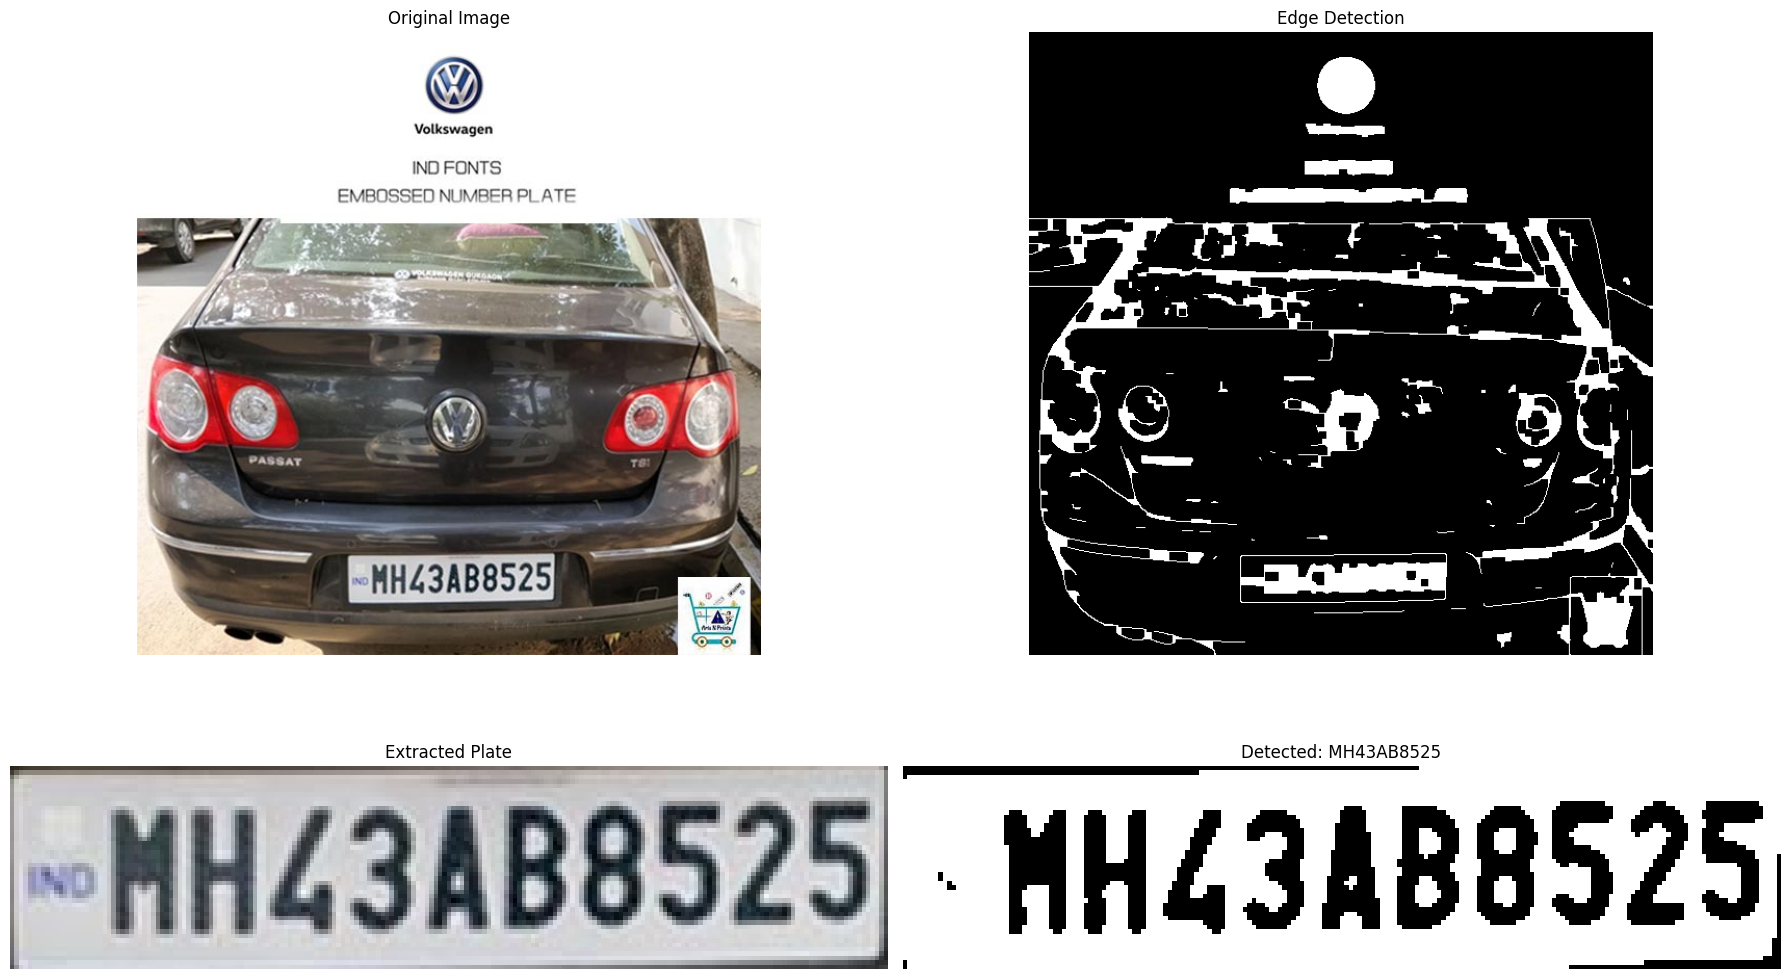


=== DETECTION RESULTS ===
License Plate: MH43AB8525


In [ ]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files
import imutils

# Install required dependencies
!sudo apt install tesseract-ocr
!pip install pytesseract imutils

def upload_image():
    """Upload image at runtime"""
    uploaded = files.upload()
    for filename in uploaded.keys():
        img = cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR)
        return img
    return None

def preprocess_image(img):
    """Image preprocessing pipeline"""
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply bilateral filter to preserve edges
    filtered = cv2.bilateralFilter(gray, 11, 17, 17)

    # Edge detection with Canny
    edged = cv2.Canny(filtered, 170, 200)

    # Morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel, iterations=3)

    return closed

def find_plate_contours(processed_img, original_img):
    """Find license plate contours using multiple verification steps"""
    # Find contours
    cnts = cv2.findContours(processed_img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # Sort by area and keep top 10
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]

    plate_contour = None

    for c in cnts:
        # Approximate contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.018 * peri, True)

        # Look for quadrilateral
        if len(approx) == 4:
            # Check aspect ratio
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)

            # Standard plate aspect ratios (adjust per country)
            if 2.5 < aspect_ratio < 4.5:
                # Verify plate has text
                roi = original_img[y:y+h, x:x+w]
                if verify_plate_text(roi):
                    plate_contour = approx
                    break

    return plate_contour

def verify_plate_text(plate_roi):
    """Verify the region contains plate-like text"""
    # Preprocess for OCR
    gray = cv2.cvtColor(plate_roi, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # OCR with strict configuration
    custom_config = r'--oem 3 --psm 11 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    text = pytesseract.image_to_string(thresh, config=custom_config)

    # Clean and verify text
    clean_text = ''.join([c for c in text if c.isalnum()])
    return len(clean_text) >= 4  # At least 4 alphanumeric characters

def extract_plate_text(img, contour):
    """Extract and enhance plate text"""
    # Get plate region
    x, y, w, h = cv2.boundingRect(contour)
    plate_img = img[y:y+h, x:x+w]

    # Preprocessing for OCR
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Advanced processing (from Kaggle approaches)
    denoised = cv2.fastNlMeansDenoising(thresh, h=10)
    sharpened = cv2.filter2D(denoised, -1, np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]))

    # OCR with LSTM
    custom_config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    text = pytesseract.image_to_string(sharpened, config=custom_config)

    # Clean text
    clean_text = ''.join([c for c in text if c.isalnum()])
    return clean_text, plate_img, sharpened

def display_results(original, processed, plate_img, ocr_img, text):
    """Professional results visualization"""
    plt.figure(figsize=(18, 12))

    # Original Image
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    # Processed Image
    plt.subplot(2, 2, 2)
    plt.imshow(processed, cmap='gray')
    plt.title("Edge Detection")
    plt.axis('off')

    # Detected Plate
    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
    plt.title("Extracted Plate")
    plt.axis('off')

    # OCR Results
    plt.subplot(2, 2, 4)
    plt.imshow(ocr_img, cmap='gray')
    plt.title(f"Detected: {text}" if text else "No Text Recognized")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def main():
    print("🚀 ADVANCED NUMBER PLATE RECOGNITION 🚀")
    print("Upload a vehicle image for plate detection:")

    # Step 1: Upload image
    img = upload_image()
    if img is None:
        print("❌ No image uploaded!")
        return

    # Step 2: Preprocess image
    processed_img = preprocess_image(img)

    # Step 3: Find plate contour
    plate_contour = find_plate_contours(processed_img, img)

    if plate_contour is None:
        print("❌ No license plate detected!")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Original Image (No Plate Found)")
        plt.axis('off')
        plt.show()
        return

    # Step 4: Extract and recognize text
    text, plate_img, ocr_img = extract_plate_text(img, plate_contour)

    # Step 5: Display results
    display_results(img, processed_img, plate_img, ocr_img, text)

    print("\n=== DETECTION RESULTS ===")
    print(f"License Plate: {text if text else 'Not recognized'}")

if __name__ == "__main__":
    main()